# Numerical Methods for Differential Equations

## Motivating example

We start with the following linear Cauchy model problem 
$$
\begin{aligned}
y^{\prime}(t) &= \lambda y(t)\\
y(0) & = 1
\end{aligned}
$$
whose exact solution is
$$
y(t) = e^{\lambda t}
$$

In [229]:
import numpy as np
import matplotlib.pyplot as plt

l = -5.
t0 = 0.
tf = 10.
y0 = 1.

s = np.linspace(t0,tf,5000)

exact = lambda x: np.exp(l*x)

### Forward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(t_{n-1},y_{n-1})
$$

In [230]:
def fe(l,y0,t0,tf,h):
    timesteps = np.arange(t0, tf+h, h)
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    for i in range(1, len(sol)):
        sol[i] = sol[i-1] * (1 + l * h)

    return sol, timesteps

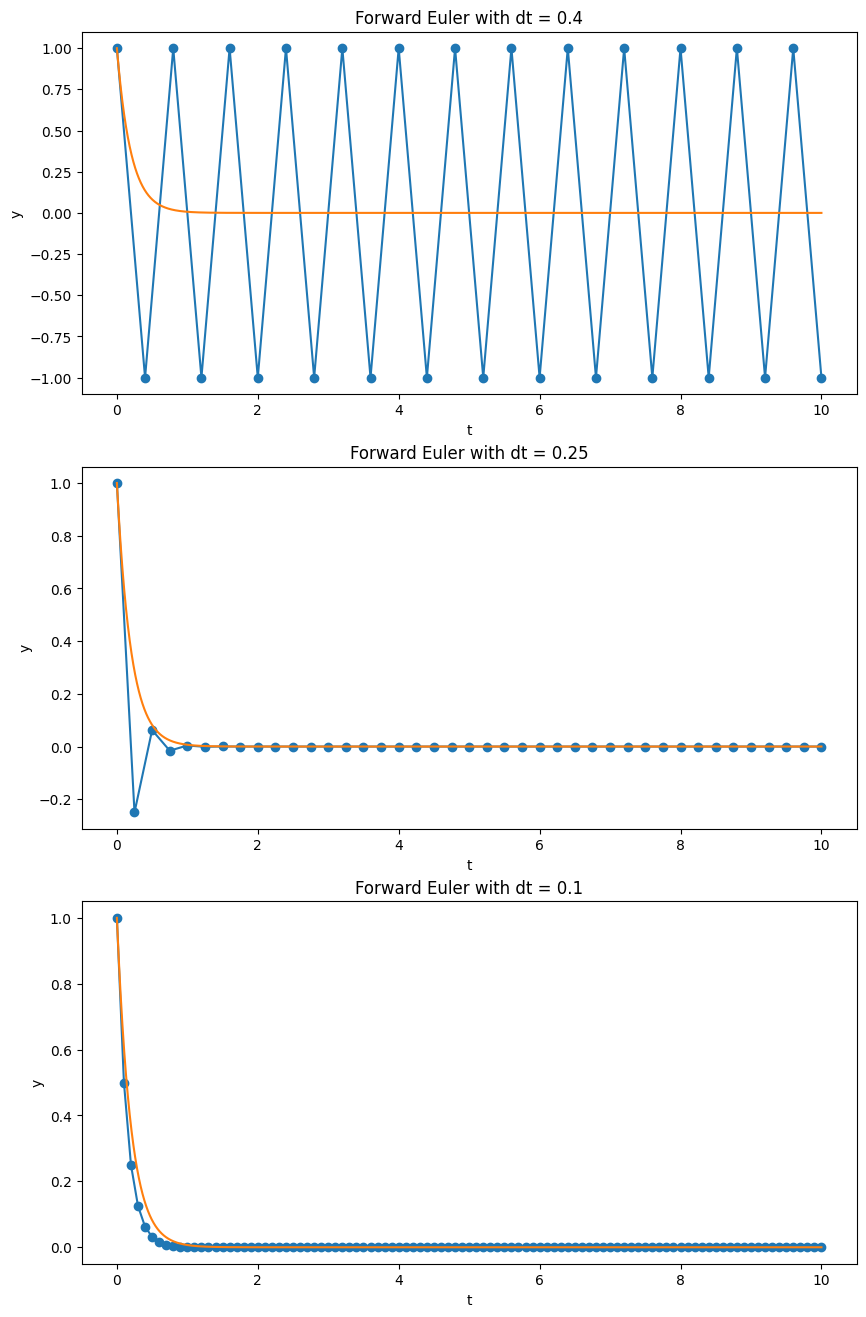

In [231]:
fig, axs = plt.subplots(3,1,figsize=(10, 16))

for (ax,dt) in zip(axs,[0.4,0.25,0.1]):
	
	# Solve the ODE using the forward Euler method
	y, t = fe(l,y0,t0,tf,dt)

	# Plot the solution
	ax.plot(t,y, 'o-')
	ax.plot(s,exact(s))

	# Add labels
	ax.set_xlabel('t')
	ax.set_ylabel('y')

	# Add a title
	ax.set_title(f'Forward Euler with dt = {dt}')

	# Compute the error
	error = np.linalg.norm(exact(t) - y, 2)

plt.show()

Indeed, we know the stability condition for Forward Euler for this problem is 
$$
h < \frac{2}{\vert \lambda \vert} = 0.4.
$$

### Backward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(t_n,y_{n})
$$

In [232]:
def be(l,y0,t0,tf,h):
    """Implement Backward Euler"""
    timesteps = np.arange(t0, tf + h, h)
    sol = np.zeros_like(timesteps)
    sol[0] = y0
    for i in range(1, len(sol)):
        sol[i] = sol[i-1] / (1 - l * h)

    return sol, timesteps

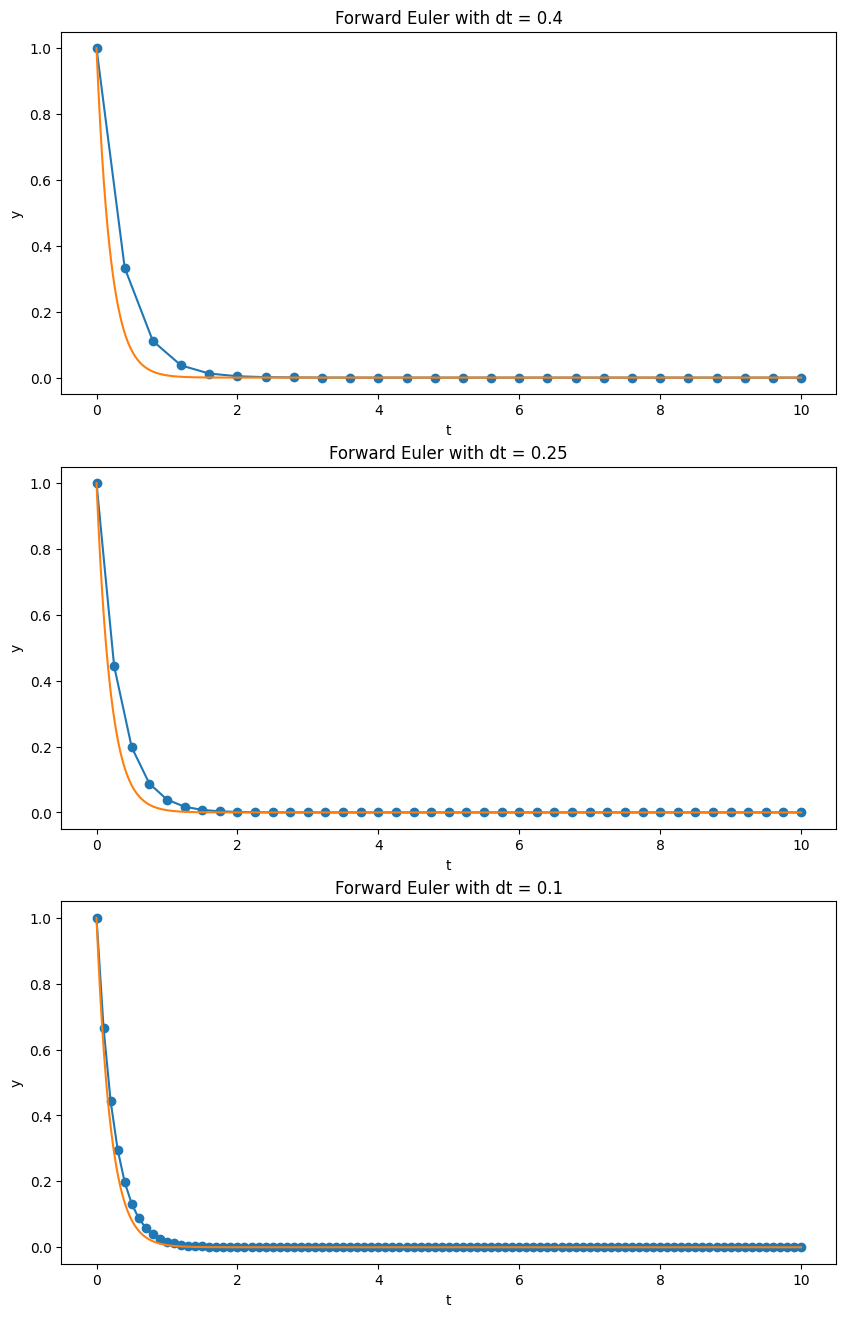

In [233]:
fig, axs = plt.subplots(3,1,figsize=(10, 16))

for (ax,dt) in zip(axs,[0.4,0.25,0.1]):
	
	# Solve the ODE using the forward Euler method
	y, t = be(l,y0,t0,tf,dt)

	# Plot the solution
	ax.plot(t,y, 'o-')
	ax.plot(s,exact(s))

	# Add labels
	ax.set_xlabel('t')
	ax.set_ylabel('y')

	# Add a title
	ax.set_title(f'Forward Euler with dt = {dt}')

	# Compute the error
	error = np.linalg.norm(exact(t) - y, 2)

plt.show()

## A more general problem

The previous implementation of the algorithms was specific to the given problem. Let us now implement the algorithms for generic forcing terms.

Using the new implementation we will solve the problem 

$$
\begin{cases}
y'(t) = 1 - y^2,\quad t>1 \\
y(0) = \frac{e^2 - 1}{e^2 + 1}
\end{cases},
$$

the exact solution of which is $y(t) = \frac{e^{2t} - 1}{e^{2t} + 1}$.


#### Forward Euler Method

The Forward Euler method for a generic forcing term $f(t,y)$ is given by:
$$
y_{n+1} = y_n + h f(t_n,y_n)
$$


In [234]:
def fe(f, y0, t0, tf, h):
	"""
	Implement Forward Euler
	f: f(t, y) function that defines the ODE
	y0: initial condition (array)
	t0: initial time
	tf: final time
	h: time step
	"""
	timesteps = np.arange(t0, tf + h, h)
	sol = np.zeros_like(timesteps)
	sol[0] = y0
	
	for i in range(1, len(sol)):
		sol[i] = sol[i-1] + h * f(timesteps[i-1], sol[i-1])
	
	return sol, timesteps

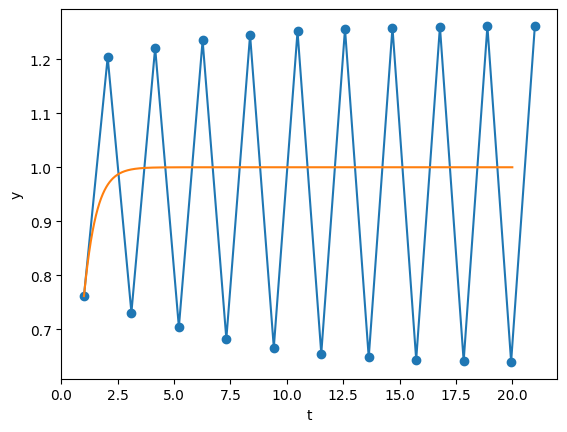

In [235]:
# Define the function f(t, y) for the given problem
f = lambda t,y : 1 - y**2

# Problem parameters
y0 = (np.exp(2) - 1)/(np.exp(2) + 1)
t0 = 1
tf = 20
dt = 20/19
tt = np.linspace(t0, tf, 1000)

exact = lambda x: (np.exp(2*x) - 1)/(np.exp(2*x) + 1)

# Solve the ODE using the forward Euler method
y, t = fe(f, y0, t0, tf, dt)

# Plot the solution
plt.plot(t, y, 'o-', label='Forward')
plt.plot(tt, exact(tt), label='Exact')

plt.xlabel('t')
plt.ylabel('y')
plt.show()


#### Backward Euler Method

The Backward Euler method for a generic forcing term $f(t,y)$ is given by:
$$
y_{n+1} = y_n + h f(y_{n+1}, t_{n+1})
$$

In [236]:
from scipy.optimize import fsolve
from newton import newton_solve

def be(f, y0, t0, tf, h):
	"""
	Implement Backward Euler
	f: f(t,y) function that defines the ODE
	y0: initial condition
	t0: initial time
	tf: final time
	h: time step
	"""
	
	timesteps = np.arange(t0, tf + h, h)
	sol = np.zeros_like(timesteps)
	sol[0] = y0

	for i in range(1, len(sol)):
		# Define the implicit function for fsolve
		g = lambda y_next: y_next - sol[i-1] - h * f(timesteps[i], y_next)
		# Use fsolve to find the root of g, starting from the previous value
		# sol[i] = fsolve(g, sol[i-1])
		sol[i] = newton_solve(g, sol[i-1], tol=1e-5)

	return sol, timesteps


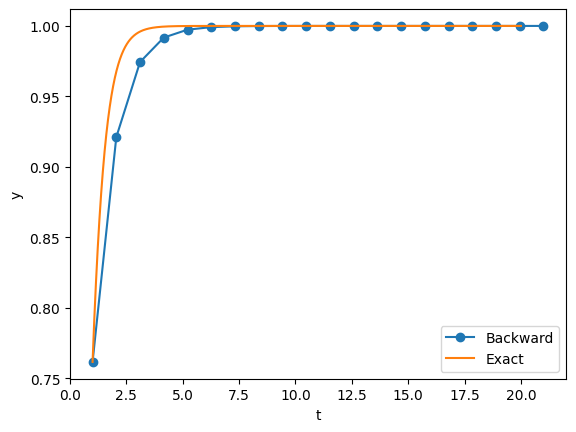

In [237]:

# Solve the ODE using the backward Euler method
y_be, t_be = be(f, y0, t0, tf, dt)

# Plot the solution
plt.plot(t_be, y_be, 'o-', label='Backward')
plt.plot(tt, exact(tt), label='Exact')

plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

## A system of nonlinear ODEs

Let us consider the Lotka-Volterra predator-prey model for two interacting populations $x$ and $y$:
$$
\begin{cases}
	\dot{x} = \alpha x - \beta xy\\
	\dot{y} = -\gamma y + \delta xy \\
	x(t_0)=x_0,\ y(t_0)=y_0.
\end{cases}
$$
Here $x$ represent the population density of a _prey_ species, and $y$ represents the population density of a _predator_ species. 
The parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ are positive constants that describe the interaction between the two species. Specifically:
- $\alpha$ is the growth rate of the prey population in the absence of predators.
- $\beta$ is the rate at which predators reduce the prey population.
- $\gamma$ is the death rate of the predator population in the absence of prey.
- $\delta$ is the rate at which the predator population increases by consuming prey.


In [238]:
def F_Lotka_Volterra(t, Y):
	"""
	Define the Lotka-Volterra system of ODEs
	t: time
	Y: array with the values of the two variables
	"""

	x, y = Y
	dx = alpha * x - beta * x * y
	dy = delta * x * y - gamma * y

	return np.array([dx, dy])

In [239]:
def fe_system(f, y0, t0, tf, h):
	"""
	Implement Forward Euler for a 2D system
	f: f(t,y) function that defines the ODE
	y0: initial condition
	t0: initial time
	tf: final time
	h: time step
	"""

	timesteps = np.arange(t0, tf + h, h)
	sol = np.zeros((len(timesteps), len(y0)))
	sol[0] = y0

	for i in range(1, len(sol)):
		sol[i] = sol[i-1] + h * f(timesteps[i-1], sol[i-1])

	return sol, timesteps


In [240]:
def be_system(f, y0, t0, tf, h):
	"""
	Implement Backward Euler for a 2D system
	f: f(t,y) function that defines the ODE
	y0: initial condition
	t0: initial time
	tf: final time
	h: time step
	"""

	timesteps = np.arange(t0, tf + h, h)
	sol = np.zeros((len(timesteps), len(y0)))
	sol[0] = y0

	for i in range(1, len(sol)):
		# Define the implicit function for fsolve
		g = lambda y_next: y_next - sol[i-1] - h * f(timesteps[i], y_next)
		# Use fsolve to find the root of g, starting from the previous value
		sol[i] = fsolve(g, sol[i-1])

	return sol, timesteps

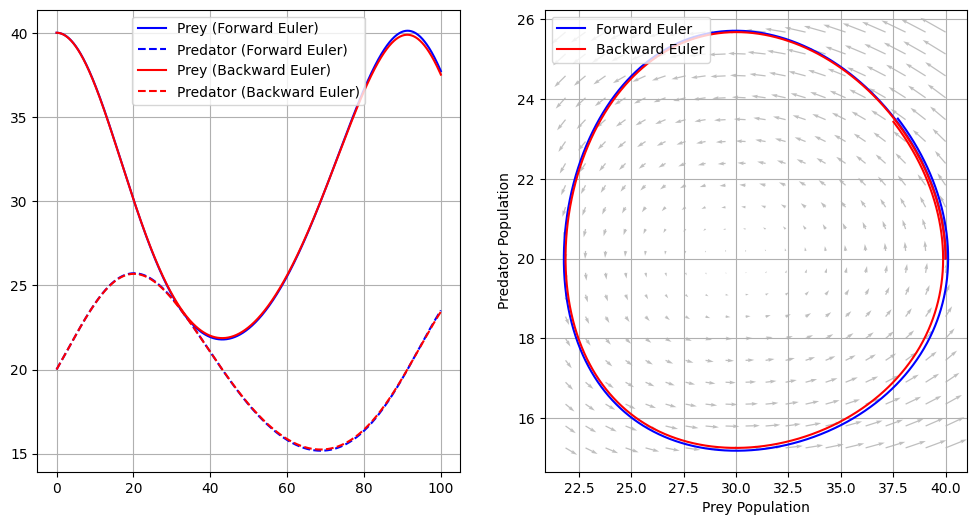

In [262]:

# Initial conditions
y0 = np.array([40, 20])
t0 = 0
tf = 100
dt = 0.05

# Parameters
alpha = 0.08
beta = 0.004
gamma = 0.06	
delta = 0.002

# Solve the ODE using the forward Euler method
y_fe, t_fe = fe_system(F_Lotka_Volterra, y0, t0, tf, dt)

# Solve the ODE using the backward Euler method
y_be, t_be = be_system(F_Lotka_Volterra, y0, t0, tf, dt)

# Plot the solution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot components
axs[0].plot(t_fe, y_fe[:,0], label='Prey (Forward Euler)', color='blue')
axs[0].plot(t_fe, y_fe[:,1], label='Predator (Forward Euler)', color='blue', linestyle='--')
axs[0].plot(t_be, y_be[:,0], label='Prey (Backward Euler)', color='red')
axs[0].plot(t_be, y_be[:,1], label='Predator (Backward Euler)', color='red', linestyle='--')
axs[0].legend()
axs[0].grid()

# Plot phase space
X, Y = np.meshgrid(np.linspace(min(y_be[:,0]), max(y_be[:,0]), 20), np.linspace(min(y_be[:,1]), max(y_be[:,1]), 20))
U = alpha * X - beta * X * Y
V = delta * X * Y - gamma * Y
axs[1].quiver(X, Y, U, V, color='gray', alpha=0.5)
axs[1].plot(y_fe[:,0], y_fe[:,1], label='Forward Euler', color='blue')
axs[1].plot(y_be[:,0], y_be[:,1], label='Backward Euler', color='red')
axs[1].set_xlabel('Prey Population')
axs[1].set_ylabel('Predator Population')
axs[1].legend(loc='upper left')
axs[1].grid()
plt.show()